This is a workbook analysing StackOverflow Yearly Survey Results

In [4]:
# Loading libraries

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
# %matplotlip inline

from scipy.stats import ttest_ind # library to perform t-test

In [5]:
# loading data

df = pd.read_csv('survey-results-public.csv')
df.shape

(51392, 154)

In [6]:
# remove rows with no gender information

df = df.dropna(subset = ['Gender'], axis = 0)
df.shape

(35047, 154)

In [9]:
# number of records by gender
df['Gender'].value_counts()

# re-categorise gender field to 'Male', 'Female' and 'Other'
df['Gender'] = np.where(df.Gender == 'Male', 'Male', np.where(df.Gender == 'Female', 'Female', 'Others'))

Male      31589
Female     2600
Others      858
Name: Gender, dtype: int64
Male      0.901332
Female    0.074186
Others    0.024481
Name: Gender, dtype: float64


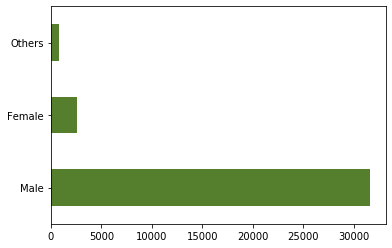

In [92]:
# Simple distribution of Gender Category
print(df['Gender'].value_counts())
print(df['Gender'].value_counts()/df.shape[0])

(df['Gender'].value_counts()).plot(kind = 'barh', color='#557f2d')

In [17]:
print("The % of male survey respondents was {:.2f}".format(sum(df.Gender == 'Male')/df.shape[0]))
print("The % of female survey respondenst was {:.2f}".format(sum(df.Gender == 'Female')/df.shape[0]))

The % of male survey respondents was 0.90
The % of female survey respondenst was 0.07


In [81]:
#  selecting only countries with at least 1% of all respondents

df_countries = ((df.groupby(['Country'])['Respondent'].count().sort_values(ascending = False)/df.shape[0])>=.01).reset_index()
df_countries = df_countries[df_countries.Respondent == True]
list_countries = list(df_countries.iloc[:, 0])

subset_df = df[df['Country'].isin(list_countries)]

print(subset_df['Gender'].value_counts())

Male      24053
Female     2068
Others      654
Name: Gender, dtype: int64


In [98]:
groups = subset_df.groupby(['Country', 'Gender'])['Respondent'].count()/subset_df.groupby(['Country'])['Respondent'].count()
groups = groups.reset_index()

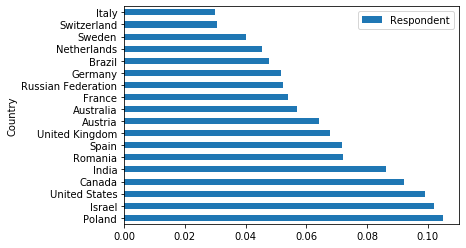

In [133]:
groups[groups.Gender == 'Female'].sort_values(by = 'Respondent', ascending = False).set_index('Country').plot(kind = 'barh')

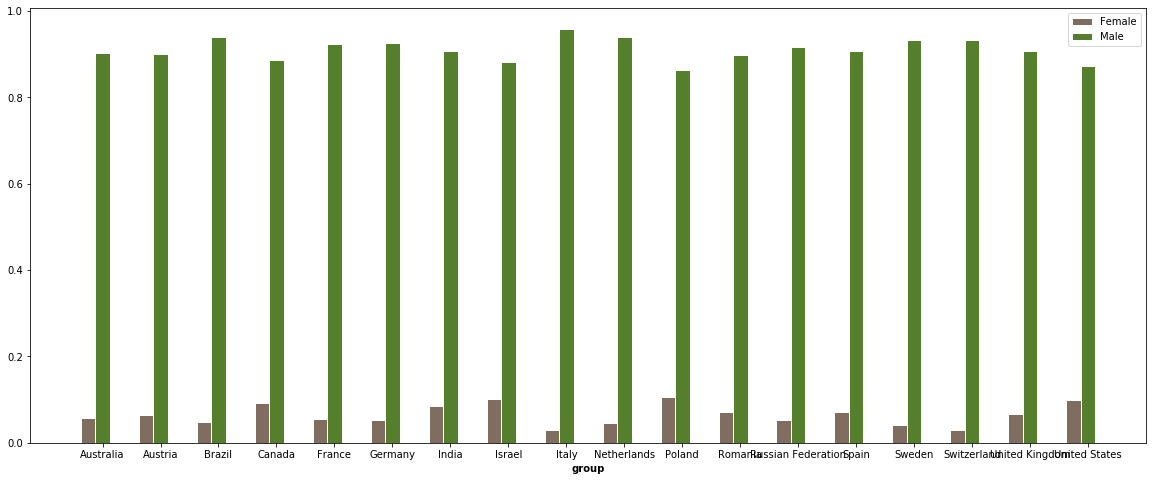

In [123]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
 
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = list(groups[groups.Gender == 'Female']['Respondent'])
bars2 = list(groups[groups.Gender == 'Male']['Respondent'])
# bars3 = list(groups[groups.Gender == 'Other']['Respondent'])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Female')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Male')
# plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], sorted(list(set(groups['Country']))))
 
# Create legend & Show graphic
plt.legend()
plt.show()


In [53]:
df_JS = df.dropna(subset = ['JobSatisfaction'], axis = 0)
df_JS.groupby('Gender')['JobSatisfaction'].mean()


cat1 = df_JS[df_JS['Gender']=='Male']
cat2 =df_JS[df_JS['Gender']=='Female']

ttest_ind(cat1['JobSatisfaction'], cat2['JobSatisfaction'])
# >>> (1.4927289925706944, 0.16970867501294376)

Ttest_indResult(statistic=1.413235478252994, pvalue=0.1575974447262672)

In [65]:
df_CS = df.dropna(subset = ['CareerSatisfaction'], axis = 0)
print(df_CS.groupby('Gender')['CareerSatisfaction'].mean())

cat1 = df_CS[df_CS['Gender']=='Male']
cat2 =df_CS[df_CS['Gender']=='Female']

ttest_ind(cat1['CareerSatisfaction'], cat2['CareerSatisfaction'])

Gender
Female    7.185069
Male      7.394061
Name: CareerSatisfaction, dtype: float64


Ttest_indResult(statistic=5.093512998370622, pvalue=3.536284963624364e-07)

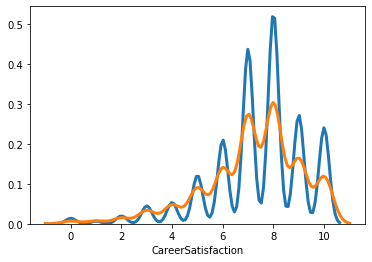

In [90]:
x1 = df_CS.loc[df_CS.Gender == 'Male', 'CareerSatisfaction']
x2 = df_CS.loc[df_CS.Gender == 'Female', 'CareerSatisfaction']
# x3 = df.loc[df.cut=='Good', 'depth']

# Draw the density plot
sns.distplot(x1, hist = False, kde = True,kde_kws = {'linewidth': 3})
sns.distplot(x2, hist = False, kde = True,kde_kws = {'linewidth': 3})

In [87]:
x2

8         8.0
10        8.0
73       10.0
111       7.0
143       5.0
         ... 
34113    10.0
34121     7.0
34150     8.0
34159     8.0
34183     7.0
Name: CareerSatisfaction, Length: 2237, dtype: float64

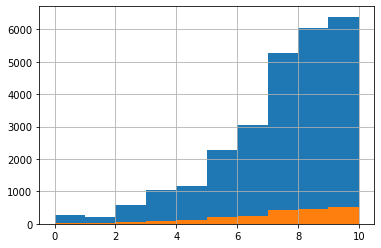

In [70]:
df_CS[df_CS['Gender']== 'Male']['JobSatisfaction'].hist()
df_CS[df_CS['Gender']== 'Female']['JobSatisfaction'].hist()

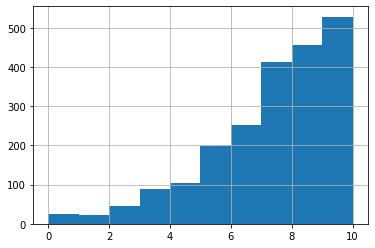

In [91]:
df_CS[df_CS['Gender']== 'Female']['JobSatisfaction'].hist()

In [96]:
df_CS = df.dropna(subset = ['Salary'], axis = 0)
print(df_CS.groupby('Gender')['Salary'].mean())

cat1 = df_CS[df_CS['Gender']=='Male']
cat2 =df_CS[df_CS['Gender']=='Female']

ttest_ind(cat1['Salary'], cat2['Salary'])

Gender
Female    58083.924534
Male      56996.494293
Name: Salary, dtype: float64


Ttest_indResult(statistic=-0.7564769929054644, pvalue=0.4493787807516285)

In [101]:
df_CS = df.dropna(subset = ['FormalEducation', 'JobSatisfaction'], axis = 0)
print(df_CS.groupby(['Gender', 'FormalEducation'])['JobSatisfaction'].mean())

Gender  FormalEducation                                                  
Female  Bachelor's degree                                                    6.988596
        Doctoral degree                                                      7.387097
        I never completed any formal education                               4.500000
        I prefer not to answer                                               6.500000
        Master's degree                                                      6.765650
        Primary/elementary school                                            6.000000
        Professional degree                                                  6.851852
        Secondary school                                                     6.978723
        Some college/university study without earning a bachelor's degree    7.021390
Male    Bachelor's degree                                                    6.910739
        Doctoral degree                                           

In [102]:
df_CS = df.dropna(subset = ['FormalEducation', 'Salary'], axis = 0)
print(df_CS.groupby(['Gender', 'FormalEducation'])['Salary'].mean())

Gender  FormalEducation                                                  
Female  Bachelor's degree                                                    60040.908291
        Doctoral degree                                                      90623.768006
        I prefer not to answer                                               13255.786387
        Master's degree                                                      56210.867588
        Primary/elementary school                                            32258.064516
        Professional degree                                                  45458.307618
        Secondary school                                                     41110.162320
        Some college/university study without earning a bachelor's degree    48116.699754
Male    Bachelor's degree                                                    57413.518034
        Doctoral degree                                                      76872.602904
        I never completed 

Gender  EmploymentStatus                                    
Female  Employed full-time                                       1998
        Employed part-time                                        167
        I prefer not to say                                        28
        Independent contractor, freelancer, or self-employed      164
        Not employed, and not looking for work                     81
        Not employed, but looking for work                        154
        Retired                                                     8
Male    Employed full-time                                      22940
        Employed part-time                                       1817
        I prefer not to say                                       350
        Independent contractor, freelancer, or self-employed     3508
        Not employed, and not looking for work                   1441
        Not employed, but looking for work                       1447
        Retired              

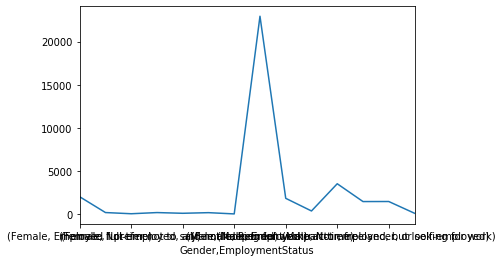

In [106]:
df_CS = df.dropna(subset = ["EmploymentStatus"], axis = 0)
print(df_CS.groupby(['Gender', 'EmploymentStatus'])['Respondent'].count())
df_CS.groupby(['Gender', 'EmploymentStatus'])['Respondent'].count().plot()